<a href="https://colab.research.google.com/github/encoras/Artificial-Intelligence-Group/blob/master/MNIST_autoencoder_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST data analysis by autoencoder in sklearn

https://i-systems.github.io/teaching/ML/iNotes/15_Autoencoder.html

### Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
RAND=123
from sklearn.neural_network import MLPRegressor


## Loading scikit-learn's MNIST Hand-Written Dataset

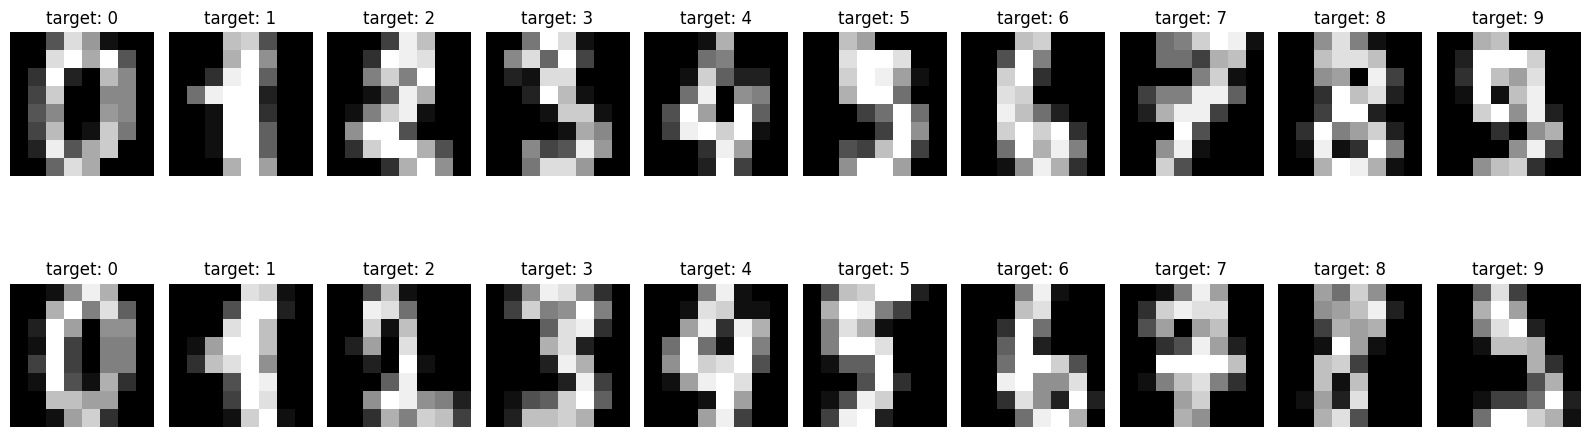

In [2]:
from sklearn.datasets import load_digits
mnist = load_digits()
fig, axes = plt.subplots(2, 10, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %10].imshow(mnist.images[i], cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title(f"target: {mnist.target[i]}")

plt.tight_layout()

In [3]:
from sklearn.model_selection import train_test_split
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)
print(X.shape)

(1797, 64)


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
nb_model = KNeighborsClassifier(n_neighbors=3, p=2)
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)
scores_base=accuracy_score(y_test,y_pred)
print("Digits Baseline accuracy = ", scores_base)

Digits Baseline accuracy =  0.9755555555555555


In [5]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

array([[51,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 42,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 41,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 51,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 48,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 41,  0,  0],
       [ 0,  4,  0,  0,  0,  0,  0,  0, 41,  0],
       [ 0,  1,  0,  2,  1,  0,  0,  0,  0, 38]])

Now define the structure of autoencoder

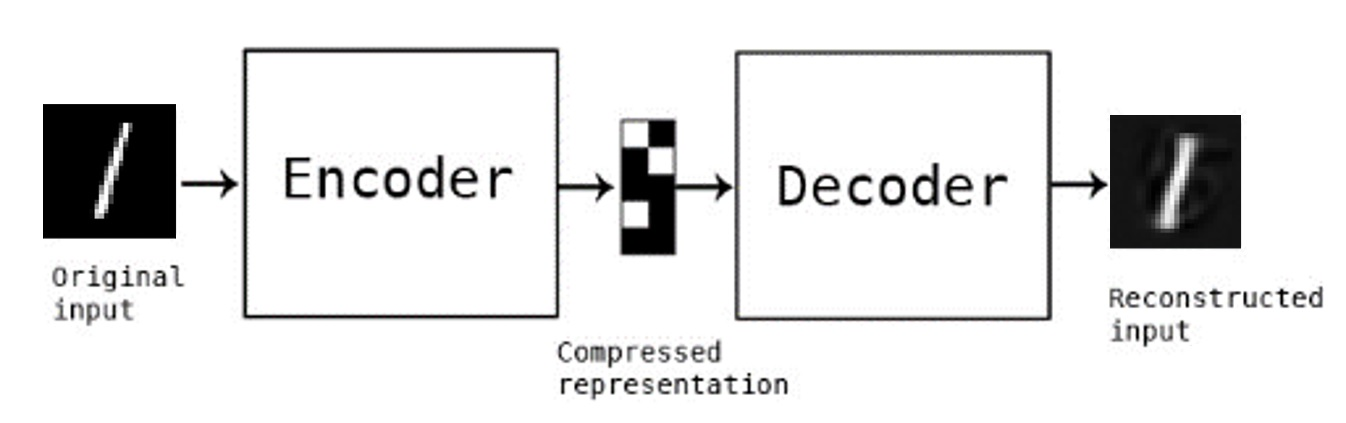



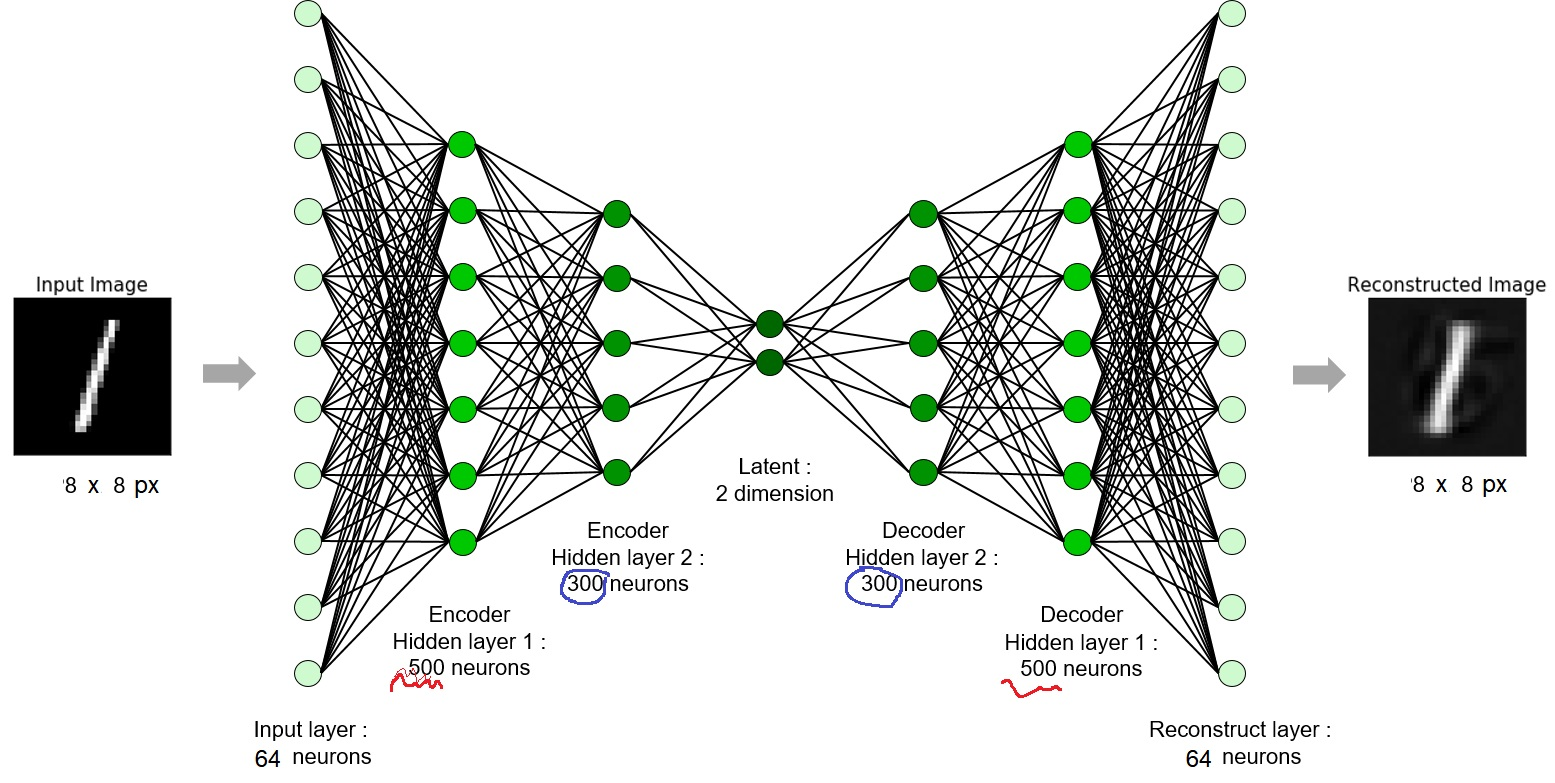

In [6]:
# Shape of input and latent variable

n_input = 8*8

# Encoder structure
n_encoder1 = 30
n_encoder2 = 15

n_latent = 2

# Decoder structure
n_decoder2 = n_encoder2
n_decoder1 = n_encoder1

Initialize the autoencoder

In [7]:
reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1),
                   activation = 'tanh',
                   solver = 'lbfgs',
                   learning_rate_init = 0.0001,
                   max_iter = 2000,
                   tol = 0.0000001,
                   verbose = True,
                   early_stopping=True)

train

In [8]:
reg.fit(X_train, X_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(activation='tanh', early_stopping=True,
             hidden_layer_sizes=(30, 15, 2, 15, 30), learning_rate_init=0.0001,
             max_iter=2000, solver='lbfgs', tol=1e-07, verbose=True)

In [9]:
print('Autoencoder Learning error = ', reg.loss_) #error should be less than 0.016 for good result

Autoencoder Learning error =  0.01248356946088048


Test or Evaluate

Test reconstruction performance of the autoencoder

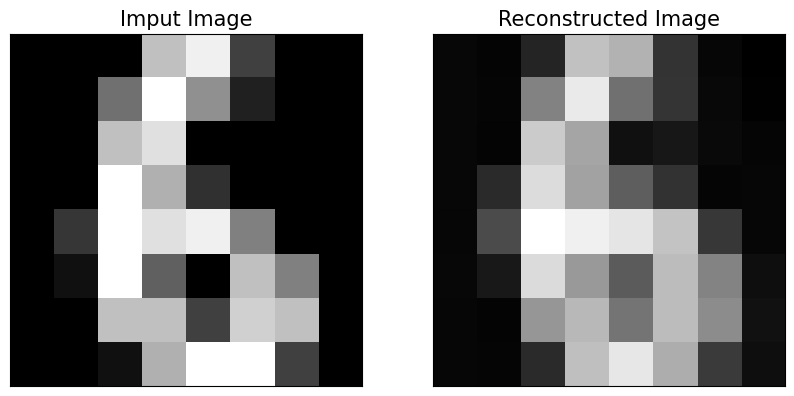

In [10]:
idx = np.random.randint(X_test.shape[0])
x_reconst = reg.predict(X_test[idx].reshape(-1,64))

plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(X_test[idx].reshape(8,8), 'gray')
plt.title('Imput Image', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(x_reconst.reshape(8,8), 'gray')
plt.title('Reconstructed Image', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.show()

Cuting out the encoder

In [11]:
def encoder(data):
    data = np.asmatrix(data)

    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))

    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))

    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))

    return np.asarray(latent)

In [12]:
X_train_latent = encoder(X_train)
X_train_latent


array([[ 0.48146636,  0.83437053],
       [ 0.19071153, -0.56959277],
       [ 0.67238925,  0.01988999],
       ...,
       [-0.58921846, -0.819735  ],
       [ 0.70719687,  0.45570376],
       [-0.38241754, -0.89368776]])

In [13]:
X_train_latent.shape

(1347, 2)

Let's plot the latent space

(np.float64(-1.0990092264445468),
 np.float64(1.0837885230652777),
 np.float64(-1.034665017902033),
 np.float64(1.0450544294712432))

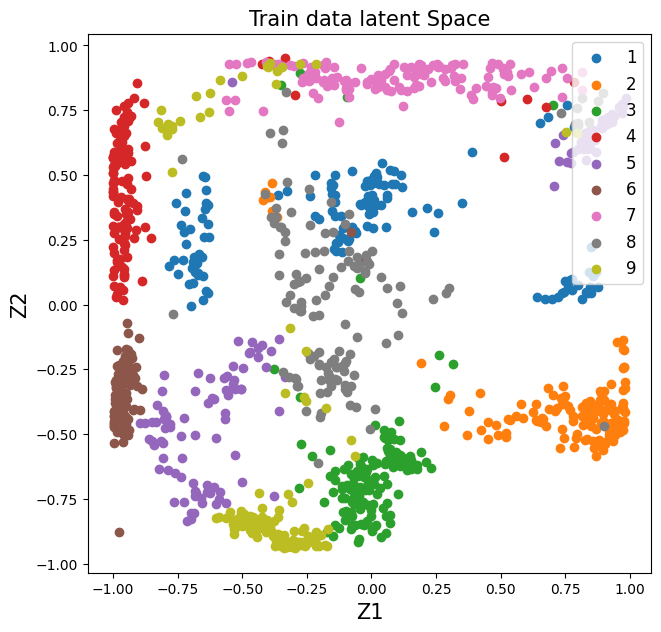

In [14]:
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(X_train_latent[np.where(y_train == 1),0], X_train_latent[np.where(y_train == 1),1], label = '1')
plt.scatter(X_train_latent[np.where(y_train == 2),0], X_train_latent[np.where(y_train == 2),1], label = '2')
plt.scatter(X_train_latent[np.where(y_train == 3),0], X_train_latent[np.where(y_train == 3),1], label = '3')
plt.scatter(X_train_latent[np.where(y_train == 4),0], X_train_latent[np.where(y_train == 4),1], label = '4')
plt.scatter(X_train_latent[np.where(y_train == 5),0], X_train_latent[np.where(y_train == 5),1], label = '5')
plt.scatter(X_train_latent[np.where(y_train == 6),0], X_train_latent[np.where(y_train == 6),1], label = '6')
plt.scatter(X_train_latent[np.where(y_train == 7),0], X_train_latent[np.where(y_train == 7),1], label = '7')
plt.scatter(X_train_latent[np.where(y_train == 8),0], X_train_latent[np.where(y_train == 8),1], label = '8')
plt.scatter(X_train_latent[np.where(y_train == 9),0], X_train_latent[np.where(y_train == 9),1], label = '9')

plt.title('Train data latent Space', fontsize = 15)
plt.xlabel('Z1', fontsize = 15)
plt.ylabel('Z2', fontsize = 15)
plt.legend(loc = 'best', fontsize = 12)
plt.axis('equal')

In [15]:
nb_model.fit(X_train_latent, y_train)
# encode the input 8*8 into 2 dim
X_test_latent  = encoder(X_test)

y_pred = nb_model.predict(X_test_latent)
scores_base=accuracy_score(y_test,y_pred)
print("ACC = ", scores_base)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)
cm

ACC =  0.8933333333333333


array([[51,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 40,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  2, 38,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  1,  0, 35,  0,  2,  0,  1,  0,  1],
       [ 0,  0,  0,  1, 49,  0,  0,  2,  0,  0],
       [ 1,  1,  0,  0,  1, 39,  0,  0,  2,  4],
       [ 1,  0,  0,  0,  1,  0, 46,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0, 39,  0,  0],
       [ 0,  7,  0,  2,  0,  4,  0,  0, 29,  3],
       [ 0,  2,  0,  2,  0,  1,  0,  1,  0, 36]])

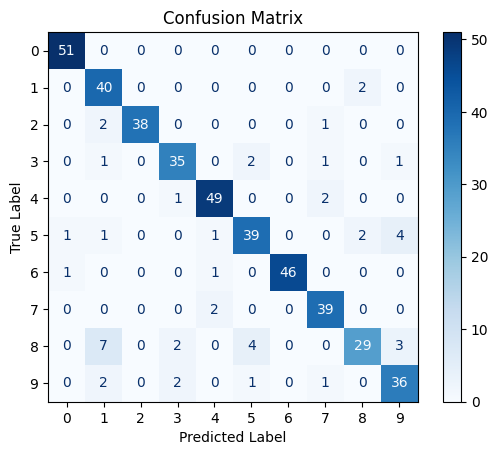

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

color = 'black'

# Create the confusion matrix display
disp = ConfusionMatrixDisplay.from_estimator(
    nb_model,
    X_test_latent,
    y_test,
    cmap=plt.cm.Blues,
    display_labels=None,
    normalize=None,
)

# Set title and axis label colors
disp.ax_.set_title('Confusion Matrix', color=color)
disp.ax_.set_xlabel('Predicted Label', color=color)
disp.ax_.set_ylabel('True Label', color=color)

# Set tick label colors
disp.ax_.tick_params(axis='x', colors=color)
disp.ax_.tick_params(axis='y', colors=color)

plt.show()

Let's use the decoder for new data generation

In [18]:
def decoder(new_data):
    new_data = np.asmatrix(new_data)
    decoder2 = new_data*reg.coefs_[3] + reg.intercepts_[3]
    decoder2 = (np.exp(decoder2) - np.exp(-decoder2))/(np.exp(decoder2) + np.exp(-decoder2))

    decoder1 = decoder2*reg.coefs_[4] + reg.intercepts_[4]
    decoder1 = (np.exp(decoder1) - np.exp(-decoder1))/(np.exp(decoder1) + np.exp(-decoder1))

    reconst = decoder1*reg.coefs_[5] + reg.intercepts_[5]
    reconst = (np.exp(reconst) - np.exp(-reconst))/(np.exp(reconst) + np.exp(-reconst))

    return np.asarray(reconst)

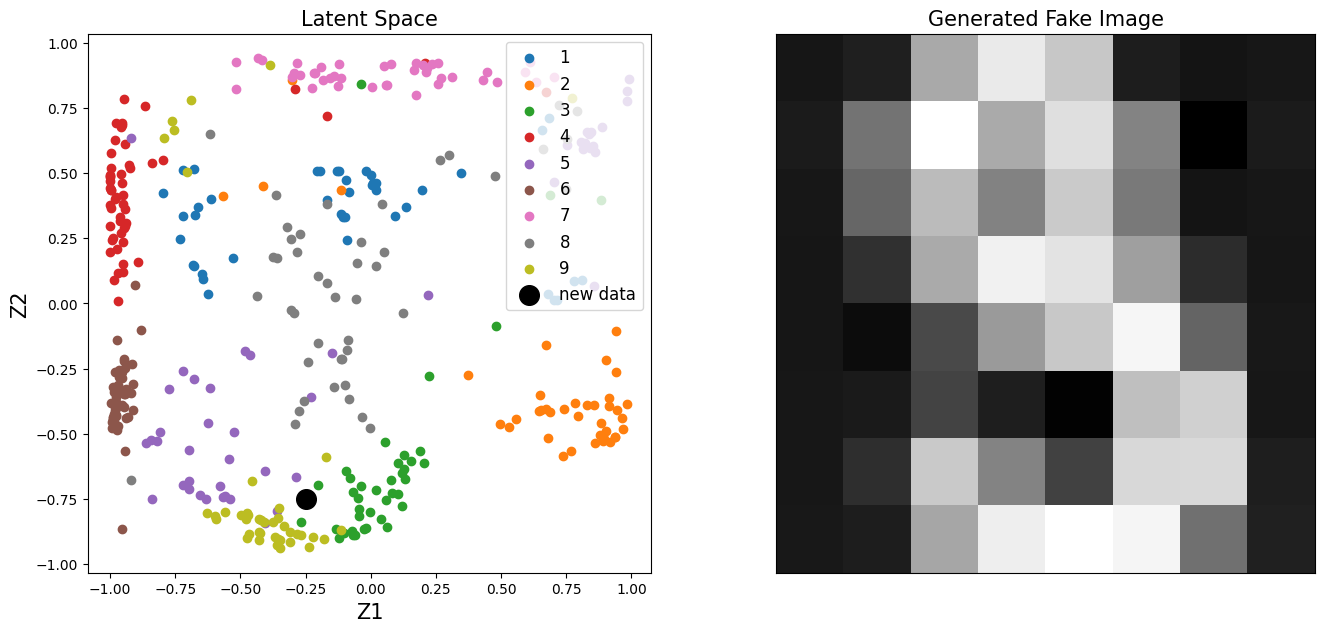

In [19]:
latent = np.array([[-0.25, -0.75]])
reconst = decoder(latent)

plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(X_test_latent[np.where(y_test == 1),0], X_test_latent[np.where(y_test == 1),1], label = '1')
plt.scatter(X_test_latent[np.where(y_test == 2),0], X_test_latent[np.where(y_test == 2),1], label = '2')
plt.scatter(X_test_latent[np.where(y_test == 3),0], X_test_latent[np.where(y_test == 3),1], label = '3')
plt.scatter(X_test_latent[np.where(y_test == 4),0], X_test_latent[np.where(y_test == 4),1], label = '4')
plt.scatter(X_test_latent[np.where(y_test == 5),0], X_test_latent[np.where(y_test == 5),1], label = '5')
plt.scatter(X_test_latent[np.where(y_test == 6),0], X_test_latent[np.where(y_test == 6),1], label = '6')
plt.scatter(X_test_latent[np.where(y_test == 7),0], X_test_latent[np.where(y_test == 7),1], label = '7')
plt.scatter(X_test_latent[np.where(y_test == 8),0], X_test_latent[np.where(y_test == 8),1], label = '8')
plt.scatter(X_test_latent[np.where(y_test == 9),0], X_test_latent[np.where(y_test == 9),1], label = '9')
plt.scatter(latent[:,0], latent[:,1], c = 'k', marker = 'o', s = 200, label = 'new data')
plt.title('Latent Space', fontsize = 15)
plt.xlabel('Z1', fontsize = 15)
plt.ylabel('Z2', fontsize = 15)
plt.legend(loc = 'best', fontsize = 12)
plt.axis('equal')
plt.subplot(1,2,2)
plt.imshow(reconst.reshape(8,8), 'gray')
plt.title('Generated Fake Image', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.show()

#Visualization¶
Image Generation

Select an arbitrary latent varibale  z
Generate images using the learned decoder

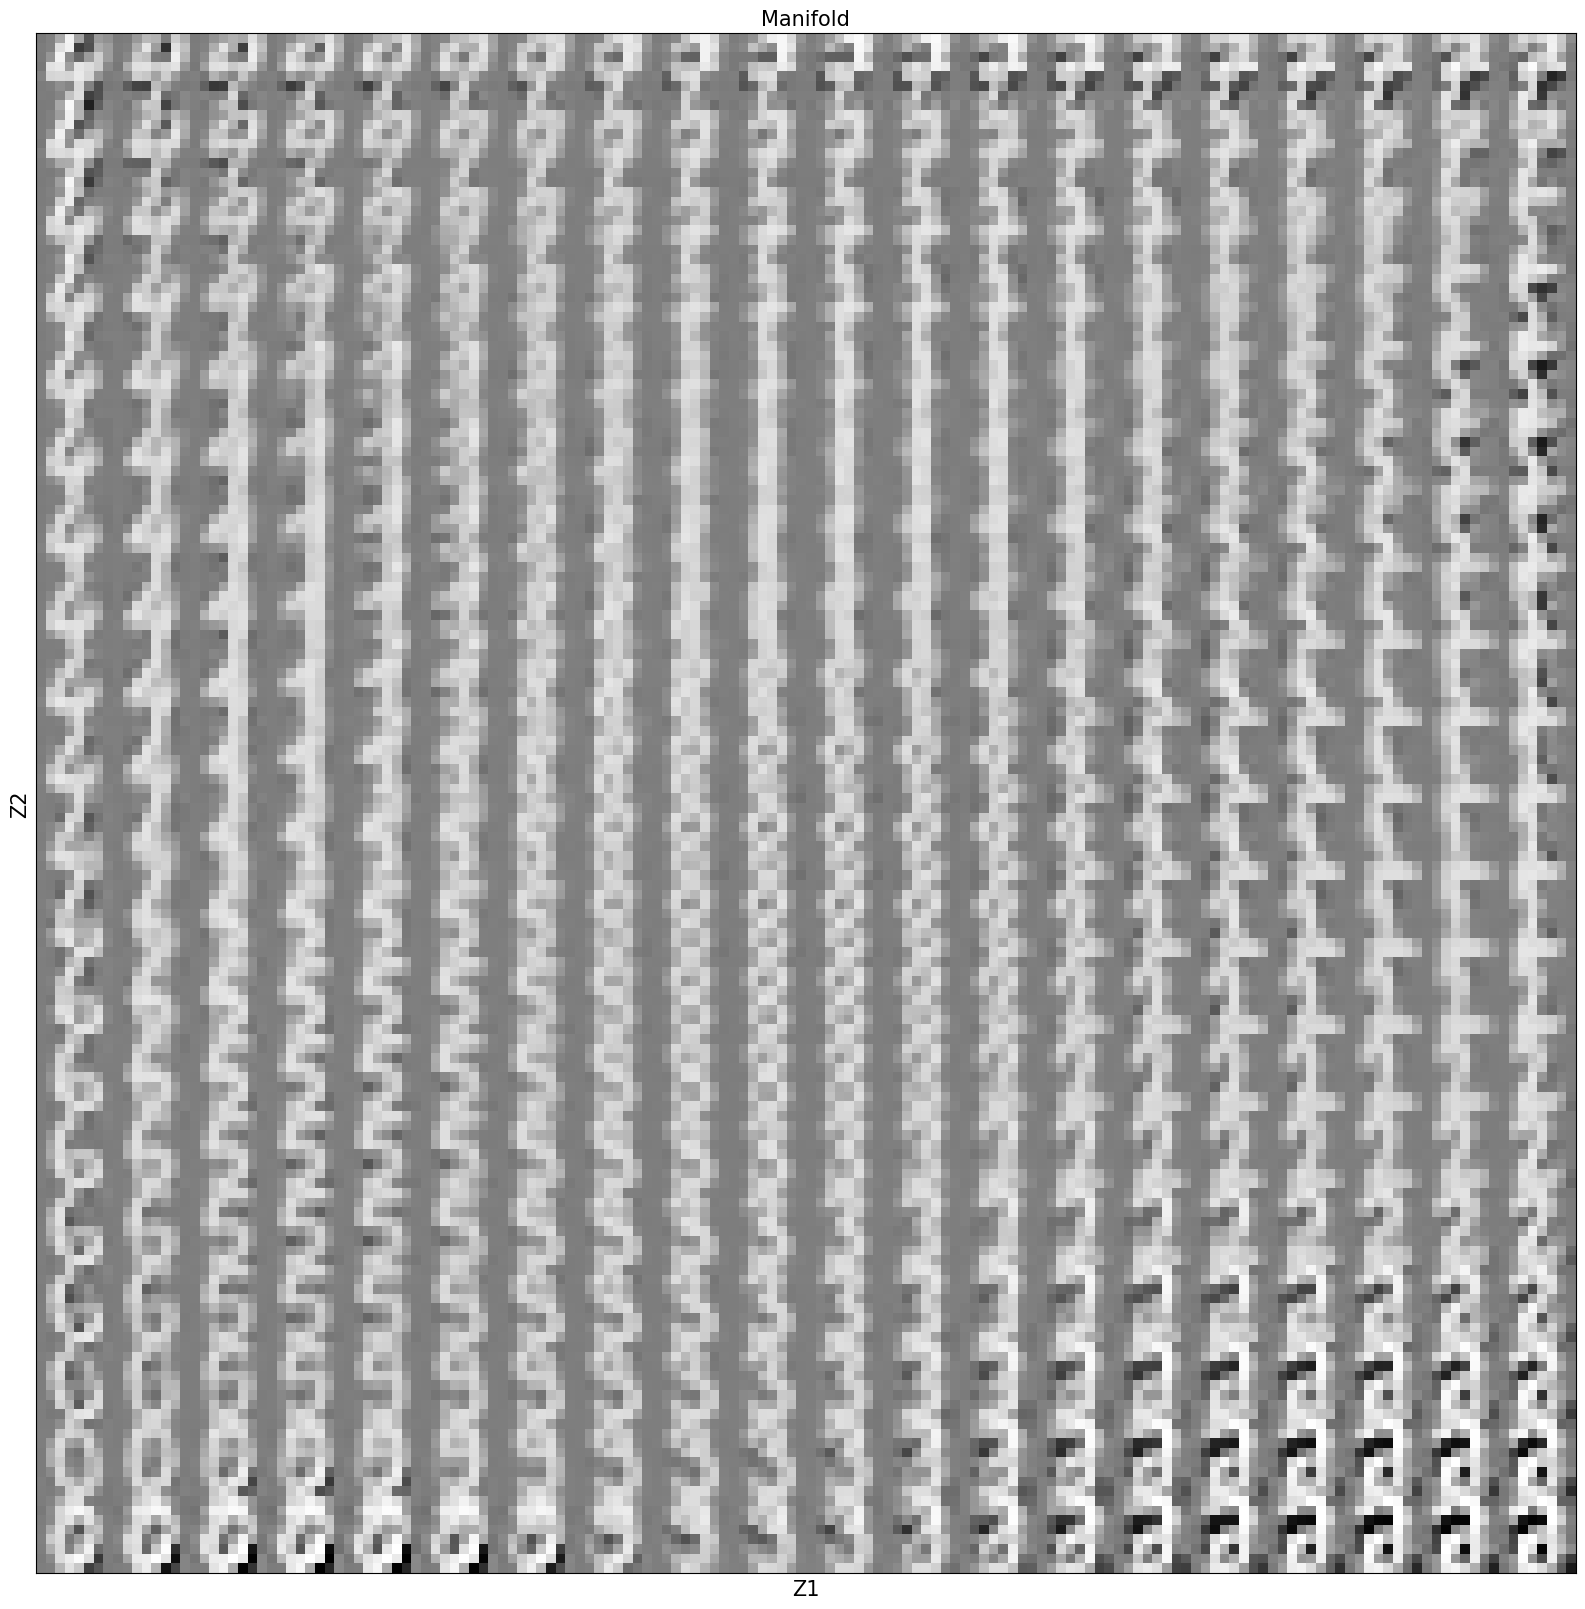

In [20]:
nx = 20
ny = 20
x_values = np.linspace(-1, 1, nx)
y_values = np.linspace(-1, 1, ny)
canvas = np.empty((8*ny, 8*nx))

for i, yi in enumerate(y_values):
        for j, xi in enumerate(x_values):
            latent = np.array([[xi, yi]])
            reconst = decoder(latent)
            canvas[(nx-i-1)*8:(nx-i)*8,j*8:(j+1)*8] = reconst.reshape(8, 8)

plt.figure(figsize = (20,20))
plt.imshow(canvas, 'gray')
plt.title('Manifold', fontsize = 15)
plt.xlabel('Z1', fontsize = 15)
plt.ylabel('Z2', fontsize = 15)
plt.xticks([])
plt.yticks([])
plt.show()